### Create Plots of Stance over Time

In [9]:
import networkx as nx
import scipy.sparse as sp
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from scipy.sparse.csgraph import connected_components
import scipy.stats as stats
import scipy.ndimage as ndimage
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from dotenv import load_dotenv
import os
import gzip
import json
from matplotlib.ticker import PercentFormatter
import pandas as pd
import psycopg2
from tldextract import extract
from tqdm import tqdm
tqdm.pandas()
import sqlite3
import numpy as np
from scipy.stats import linregress
load_dotenv()
db_path = os.getenv('db_path')

In [33]:
df = pd.read_csv("../../Data/StanceDetectionData/df_final_labelled.csv.gz")
df["classification_int"] = df["stance"].replace({"Palestine":-1, "Neutral":0, "Israel":1})

df["createdat"] = pd.to_datetime(df["createdat"])
mapping = {-1: "Palestine", 0: "Neutral", 1: "Israel"}
df["classification"] = df["classification_int"].map(mapping)

# Group the data by day and classification, and count the occurrences
daily_counts = (
    df[
        ~df.did.isin(
            df.groupby("did").size().sort_values(ascending=False).head(50).index
        )
    ]
    .groupby([pd.Grouper(key="createdat", freq="D"), "classification"])
    .size()
    .unstack()
)

# Calculate the percentage of each classification per day
daily_percentage = daily_counts.div(daily_counts.sum(axis=1), axis=0)

monthly_counts = (
    df[
        ~df.did.isin(
            df.groupby("did").size().sort_values(ascending=False).head(50).index
        )
    ]
    .groupby([pd.Grouper(key="createdat", freq="M"), "classification"])
    .size()
    .unstack()
)

monthly_percentage = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

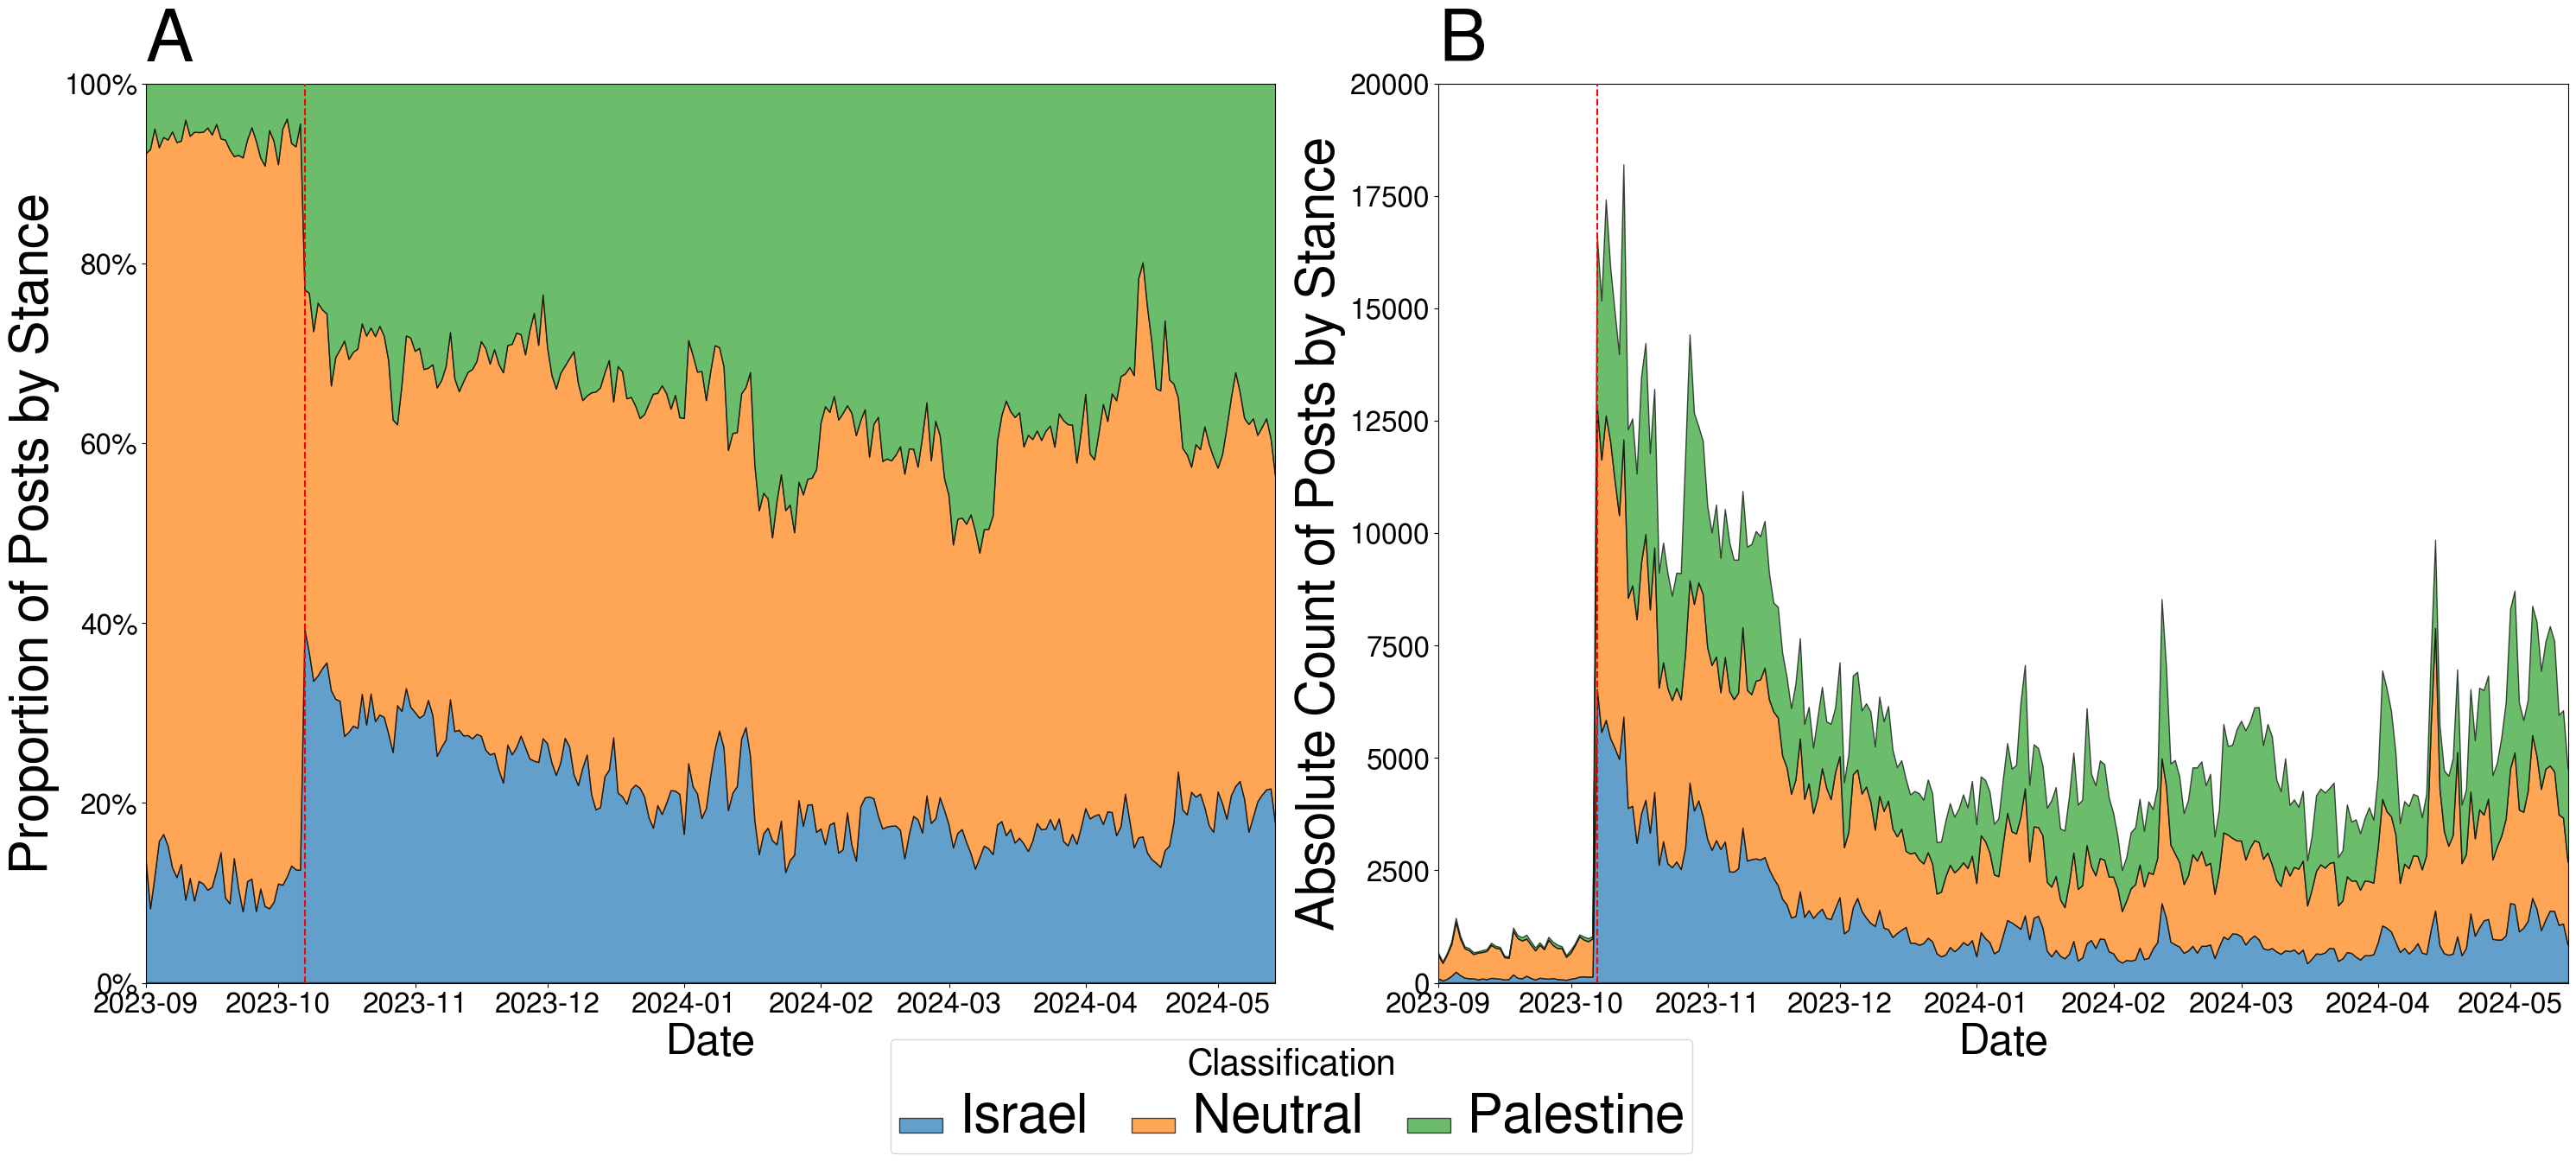

In [36]:
# Set the font to Arial (or Helvetica or FreeSans as fallbacks)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'FreeSans']

fig, axs = plt.subplots(1, 2, figsize=(30, 12))

daily_counts = (
    df.groupby([pd.Grouper(key="createdat", freq="D"), "classification"])
    .size()
    .unstack()
)
daily_percentage = daily_counts.div(daily_counts.sum(axis=1), axis=0)

axs[0].stackplot(
    daily_percentage.index,
    daily_percentage.T,
    labels=daily_percentage.columns,
    alpha=0.7,
    edgecolor="black",
)
axs[0].set_xlabel("Date", fontsize=36)
axs[0].set_ylabel("Proportion of Posts by Stance", fontsize=44)

axs[1].stackplot(
    daily_counts.index,
    daily_counts.T,
    labels=daily_counts.columns,
    alpha=0.7,
    edgecolor="black",
)
axs[1].set_xlabel("Date", fontsize=36)
axs[1].set_ylabel("Absolute Count of Posts by Stance", fontsize=44)

axs[0].set_xlim(pd.to_datetime("2023-09-01"), pd.to_datetime("2024-05-14"))
axs[0].axvline(pd.to_datetime("2023-10-07"), color="red", linestyle="--", zorder=1000)
axs[1].set_xlim(pd.to_datetime("2023-09-01"), pd.to_datetime("2024-05-14"))
axs[1].axvline(pd.to_datetime("2023-10-07"), color="red", linestyle="--", zorder=1000)

axs[0].set_ylim(0, 1)
axs[1].set_ylim(0, 20000)

axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

axs[0].tick_params(axis="both", which="major", labelsize=24)
axs[1].tick_params(axis="both", which="major", labelsize=24)

handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(
    handles,
    labels,
    title="Classification",
    title_fontsize=30,
    fontsize=18,
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.175),  
)


labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X"]
for idx, ax in enumerate(axs.flat):
    ax.text(0, 1.025, labels[idx], transform=ax.transAxes, fontsize=60)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Adjust the bottom value to provide more space 

for text in legend.get_texts():
    text.set_fontsize(45)

plt.subplots_adjust(bottom=0.)  # Adjust the bottom spacing
plt.savefig("../../Plots/PostsByStance.png", dpi = 300, bbox_inches='tight')
plt.savefig("../../Plots/PostsByStance.pdf", dpi = 300, bbox_inches='tight')

In [8]:
conn = sqlite3.connect(db_path)


queries = [
    (
        "reposts",
        "SELECT subject_cid, COUNT(*) AS repost_count FROM reposts GROUP BY subject_cid",
        "Number of Reposts per Post",
        "Posts",
    ),
    (
        "Posts",
        "SELECT reply_root_cid, COUNT(*) AS thread_length FROM Posts WHERE reply_root_cid IS NOT NULL AND reply_root_cid != '' GROUP BY reply_root_cid",
        "Thread Length",
        "Posts",
    ),
    (
        "Posts",
        "SELECT did, COUNT(*) AS post_count FROM Posts GROUP BY did",
        "Number of Posts per User",
        "Users",
    ),
    (
        "Blocks",
        "SELECT did, COUNT(*) AS blocked_count FROM Blocks GROUP BY did",
        "Number of People Blocked",
        "Users",
    ),
    (
        "Blocks",
        "SELECT subject, COUNT(*) AS blocked_by_count FROM Blocks GROUP BY subject",
        "Number of People Blocked By",
        "Users",
    ),
    (
        "follows",
        "SELECT DID, COUNT(*) AS follow_count FROM follows GROUP BY DID",
        "Number of People Followed by User",
        "Users",
    ),
    (
        "follows",
        "SELECT subject AS user_id, COUNT(*) AS follower_count FROM follows GROUP BY subject",
        "Number of Followers",
        "Users",
    ),
    
    (
        "Likes",
        "SELECT subject_cid, COUNT(*) AS like_count FROM Likes GROUP BY subject_cid",
        "Number of Likes per Post",
        "Posts",
    ),
]

# Create a dictionary to store the data for each query
data_dict = {}

# Iterate over each query
for table, query, title, xlabel in queries:
    print(f"Processing {title}...")

    # Execute the query
    cur = conn.cursor()
    cur.execute(query)
    counts = [row[1] for row in cur.fetchall()]
    cur.close()

    # Sort the counts in descending order
    sorted_counts = sorted(counts, reverse=True)

    # Generate a rank for each count, which will be used as the x-axis values
    ranks = np.arange(1, len(sorted_counts) + 1)

    # Save the data in the dictionary
    data_dict[title] = {
        "counts": sorted_counts,
        "ranks": ranks,
        "xlabel": xlabel,
        "table": table,
    }

# Close the database connection
conn.close()

Processing Number of Reposts per Post...


In [1]:
with open("../../data_dict.pkl", "rb") as f:
    data_dict = pickle.load(f)

with gzip.open("../../like_counts.json.gz", "rt") as f:
    final_like_counts = json.load(f)

with open("../../quote_counts.pkl","rb") as f:
    quote_counts = pickle.load(f)

In [2]:
# Convert the list to a numpy array for easier manipulation
like_counts_array = np.array(final_like_counts)

# Generate ranks (x-axis values)
ranks = np.arange(1, len(final_like_counts) + 1)

# Update the data_dict with the new information
data_dict["Number of Likes per Post"] = {
    "counts": like_counts_array,
    "ranks": ranks,
    "xlabel": "Posts",
    "table": "Likes"
}

quote_counts_array = np.array(quote_counts)
ranks = np.arange(1, len(quote_counts) + 1)
data_dict["Number of Quotes per Post"] = {
    "counts": quote_counts_array,
    "ranks": ranks,
    "xlabel": "Posts",
    "table": "Posts"
}

In [3]:
def compute_CCDF(data, normalize=True):
    x = np.sort(data)[::-1]
    counts = x.size - np.searchsorted(x[::-1],x[::-1],side='left') # we need searchsorted to take into account duplicated values

    if normalize:
        counts = np.array(counts)/ sum(counts)
    return x[::-1], counts


def find_exponent(degree_sequence, MIN):
  degree_sequence = np.array(degree_sequence)
  degree_sequence=degree_sequence[np.where(degree_sequence>=MIN)]
  return 1+len(degree_sequence)/ sum([np.log(k_i/MIN) for k_i in degree_sequence ])

In [4]:
def get_statistics(distribution):
    """
    Returns (dict):
        - mean μ, 
        - standard deviation σ, 
        - skewness γ, 
        - kurtosis β, 
        - minimum m, 
        - maximum M
        - mean over maximum ratio
    """
    μ = np.mean(distribution)
    σ = np.std(distribution)
    γ = np.mean((distribution - μ) ** 3) / σ ** 3
    β = np.mean((distribution - μ) ** 4) / σ ** 4
    m = np.min(distribution)
    M = np.max(distribution)
    ratio = μ/M
    exponent = find_exponent(distribution, 1)
    return {
        "mean": μ,
        "std": σ,
        "skewness": γ,
        "kurtosis": β,
        "min": m,
        "max": M,
        "ratio": ratio,
        "power_law_exponent": exponent,
    }

results = {}

for key in tqdm(data_dict):
    print(key)
    results[key] = get_statistics(data_dict[key]["counts"])
d = pd.DataFrame(results).T
d["ratio"] = d["ratio"] * 10**3

# Number of digits = 3
print(d.sort_values("mean").to_latex(float_format="%.3f").replace(".000","").replace("Number of", "\#"))

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [23:29<00:00, 156.65s/it]


\begin{tabular}{lrrrrrrrr}
\toprule
 & mean & std & skewness & kurtosis & min & max & ratio & power_law_exponent \\
\midrule
\# Quotes per Post & 1.682 & 6.003 & 149.259 & 67646.663 & 1 & 4455 & 0.377 & 5.441 \\
\# Likes per Post & 2.148 & 9.521 & 5355.320 & 53468722.557 & 1 & 102123 & 0.021 & 3.702 \\
\# Reposts per Post & 4.140 & 20.348 & 141.972 & 70043.802 & 1 & 18765 & 0.221 & 2.503 \\
Thread Length & 4.185 & 62.836 & 4780.687 & 23736718.688 & 1 & 312092 & 0.013 & 2.145 \\
\# People Blocked By & 8.155 & 81.228 & 70.535 & 9086.269 & 1 & 18234 & 0.447 & 2.122 \\
\# People Blocked & 19.494 & 838.448 & 340.712 & 123106.559 & 1 & 324147 & 0.060 & 1.900 \\
\# People Followed by User & 38.952 & 343.076 & 203.031 & 71572.734 & 1 & 208288 & 0.187 & 1.441 \\
\# Followers & 43.231 & 668.036 & 516.367 & 498518.321 & 1 & 755584 & 0.057 & 1.527 \\
\# Posts per User & 89.601 & 1061.988 & 501.547 & 450864.562 & 1 & 1059206 & 0.085 & 1.458 \\
\bottomrule
\end{tabular}



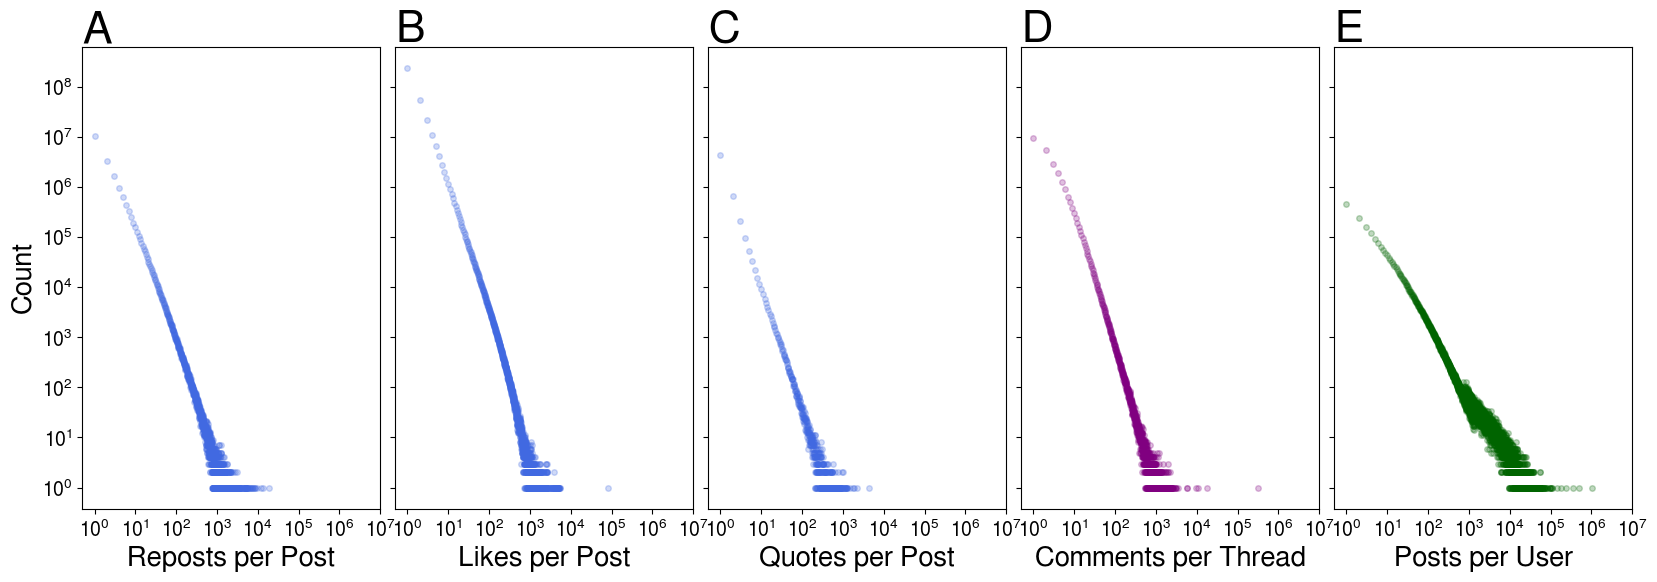

In [14]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'FreeSans']

fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharey=True, sharex=True)
axs = axs.flatten()
fontsize = 16
titlesize = 20
markersize = 16
labsize = 18
ticksize = 14
grid_bool = False
markeralpha = 0.25
markercolor = "#0000ff"
num_bins = 10**4
# y-ticks 10^0 to 10^8
# x-ticks 10^0 to 10^5
y_ticks = [10**i for i in range(9)]
x_ticks = [10**i for i in range(8)]


counts = data_dict["Number of Reposts per Post"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[0].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#4169e1"
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Reposts per Post", fontsize=titlesize)
axs[0].set_ylabel("Count", fontsize=titlesize)
axs[0].tick_params(axis="x", labelsize=ticksize)
axs[0].tick_params(axis="y", labelsize=ticksize)
axs[0].grid(grid_bool)


# Plotting "Number of Likes per Post"
counts = data_dict["Number of Likes per Post"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[1].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#4169e1"
)

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Likes per Post", fontsize=titlesize)
axs[1].tick_params(axis="x", labelsize=ticksize)
axs[1].grid(grid_bool)

# Plotting Quote Counts
counts = data_dict["Number of Quotes per Post"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[2].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#4169e1"
)

axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("Quotes per Post", fontsize=titlesize)
axs[2].tick_params(axis="x", labelsize=ticksize)
axs[2].grid(grid_bool)


# Plotting "Thread Length"
counts = data_dict["Thread Length"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[3].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#800080"
)

axs[3].set_xscale("log")
axs[3].set_yscale("log")
axs[3].set_xlabel("Comments per Thread", fontsize=titlesize)
axs[3].tick_params(axis="x", labelsize=ticksize)
axs[3].grid(grid_bool)

# Plotting "Number of Posts per User"
counts = data_dict["Number of Posts per User"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[4].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#006400"
)

axs[4].set_xscale("log")
axs[4].set_yscale("log")
axs[4].set_xlabel("Posts per User", fontsize=titlesize)
axs[4].tick_params(axis="x", labelsize=ticksize)
axs[4].grid(grid_bool)


for ax in axs:
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
# Hide y-axis labels for the second and third subplots
for ax in axs[1:]:
    ax.yaxis.set_tick_params(labelleft=False)


labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X"]
for ax in axs:
    min_val = min([ax.get_ylim()[0] for ax in axs])
    max_val = max([ax.get_ylim()[1] for ax in axs]) 
    #max_val = 10**6
    ax.set_ylim(min_val, max_val)

for idx, ax in enumerate(axs.flat):
    ax.text(0.0, 1.01, labels[idx], transform=ax.transAxes, fontsize=32)

# Adjust layout
plt.subplots_adjust(wspace=0.05)
plt.savefig("../../Plots/Post_dist.png", dpi=300, bbox_inches="tight")
plt.savefig("../../Plots/Post_dist.pdf", bbox_inches="tight")

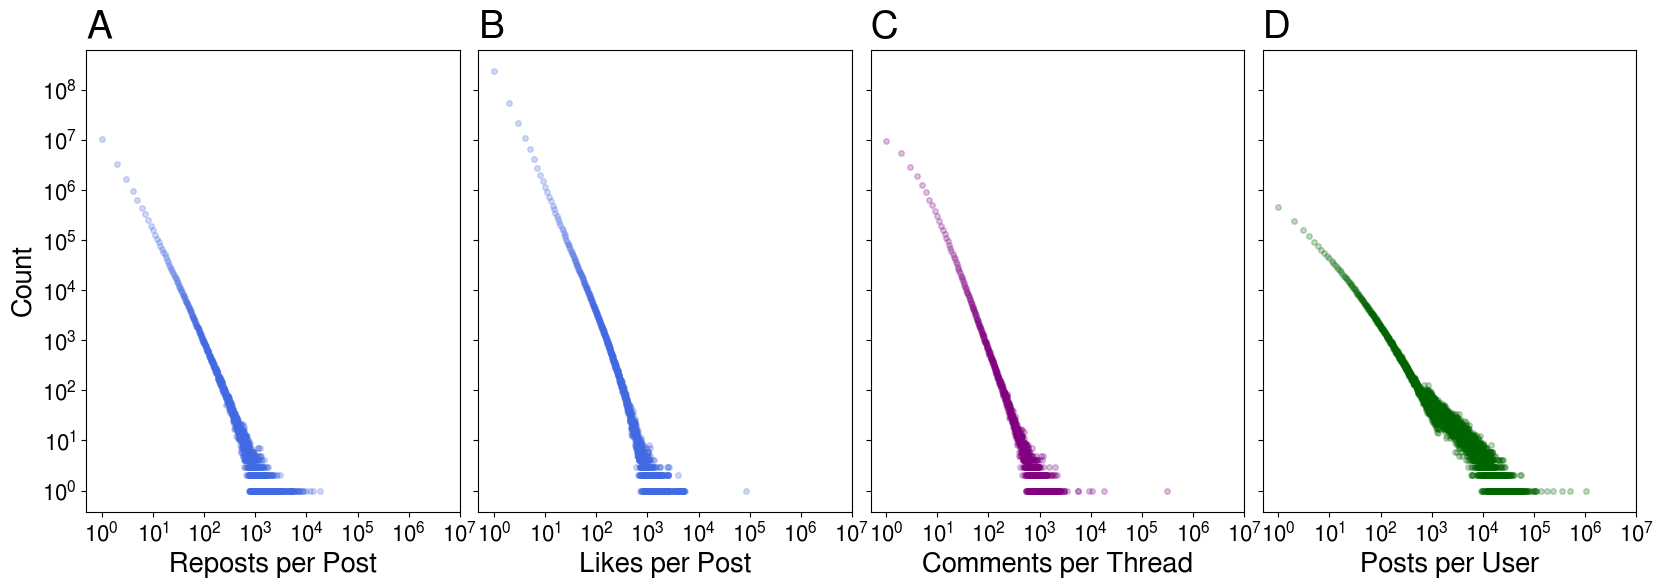

In [9]:
import matplotlib
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'FreeSans']

fig, axs = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)
axs = axs.flatten()
fontsize = 16
titlesize = 20
markersize = 16
labsize = 18
grid_bool = False
markeralpha = 0.25
markercolor = "#0000ff"
num_bins = 10**4
# y-ticks 10^0 to 10^8
# x-ticks 10^0 to 10^5
y_ticks = [10**i for i in range(9)]
x_ticks = [10**i for i in range(8)]


counts = data_dict["Number of Reposts per Post"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[0].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#4169e1"
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
#axs[0].set_title("Reposts per Post", fontsize=titlesize)
axs[0].set_xlabel("Reposts per Post", fontsize=titlesize)
axs[0].set_ylabel("Count", fontsize=titlesize)
axs[0].tick_params(axis="x", labelsize=fontsize)
axs[0].tick_params(axis="y", labelsize=fontsize)
axs[0].grid(grid_bool)


# Plotting "Number of Likes per Post"
counts = data_dict["Number of Likes per Post"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[1].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#4169e1"
)

axs[1].set_xscale("log")
axs[1].set_yscale("log")
#axs[1].set_title("Likes per Post", fontsize=titlesize)
axs[1].set_xlabel("Likes per Post", fontsize=titlesize)
axs[1].tick_params(axis="x", labelsize=fontsize)
axs[1].grid(grid_bool)

# Plotting "Thread Length"
counts = data_dict["Thread Length"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[2].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#800080"
)

axs[2].set_xscale("log")
axs[2].set_yscale("log")
#axs[2].set_title("Comments per Thread", fontsize=titlesize)
axs[2].set_xlabel("Comments per Thread", fontsize=titlesize)
axs[2].tick_params(axis="x", labelsize=fontsize)
axs[2].grid(grid_bool)

# Plotting "Number of Posts per User"
counts = data_dict["Number of Posts per User"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5
axs[3].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#006400"
)

axs[3].set_xscale("log")
axs[3].set_yscale("log")
#axs[3].set_title("Posts per User", fontsize=titlesize)
axs[3].set_xlabel("Posts per User", fontsize=titlesize)
axs[3].tick_params(axis="x", labelsize=fontsize)
axs[3].grid(grid_bool)

for ax in axs:
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
# Hide y-axis labels for the second and third subplots
for ax in axs[1:]:
    ax.yaxis.set_tick_params(labelleft=False)


labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X"]
for ax in axs:
    min_val = min([ax.get_ylim()[0] for ax in axs])
    max_val = max([ax.get_ylim()[1] for ax in axs]) 
    #max_val = 10**6
    ax.set_ylim(min_val, max_val)

for idx, ax in enumerate(axs.flat):
    ax.text(0.0, 1.025, labels[idx], transform=ax.transAxes, fontsize=28)

# Adjust layout
plt.subplots_adjust(wspace=0.05)
plt.savefig("../../Plots/Post_dist.png", dpi=300, bbox_inches="tight")
plt.savefig("../../Plots/Post_dist.pdf", bbox_inches="tight")

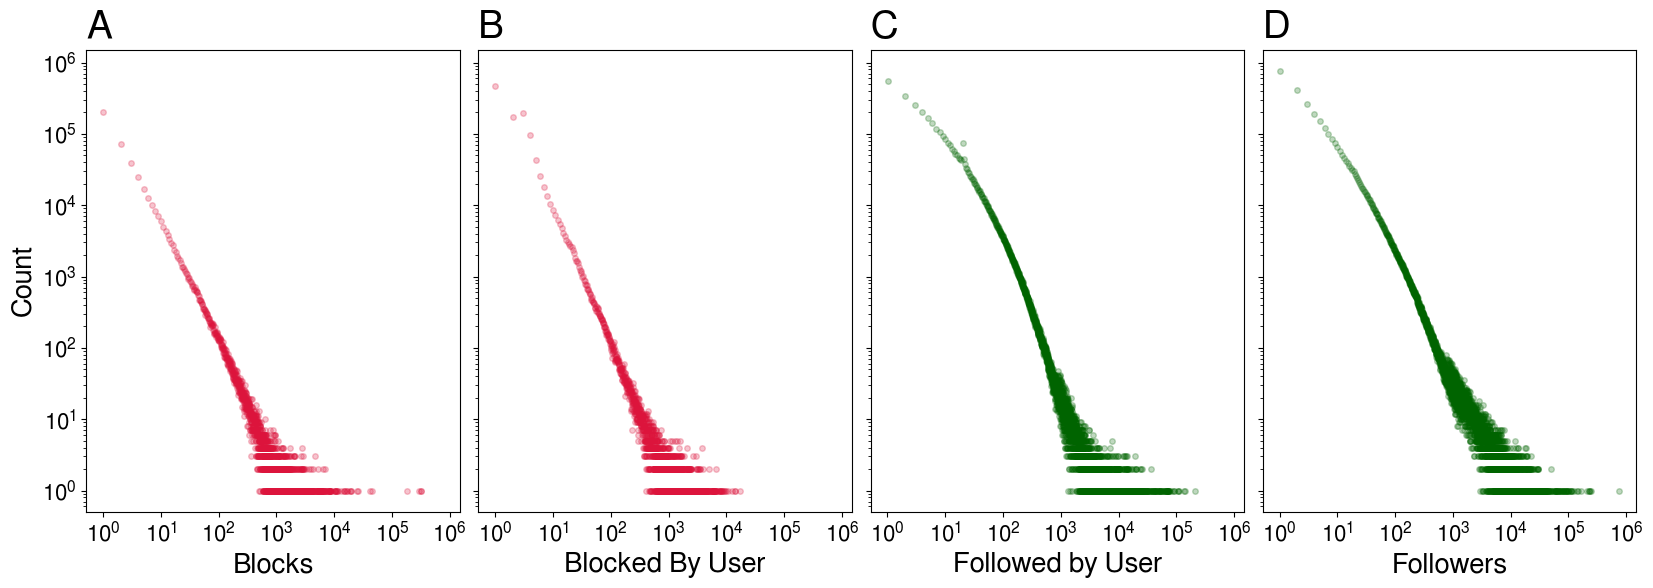

In [12]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'FreeSans']

# Plot configurations
fontsize = 16
titlesize = 20
markersize = 16
labsize = 18
grid_bool = False
markeralpha = 0.25
num_bins = 10**4
y_ticks = [10**i for i in range(9)]
x_ticks = [10**i for i in range(8)]

# Set up the figure and axes
fig, axs = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)

counts = data_dict["Number of People Blocked"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5

axs[0].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#dc143c"
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Blocks", fontsize=titlesize)
axs[0].set_ylabel("Count", fontsize=titlesize)
axs[0].set_xticks(x_ticks)
axs[0].set_yticks(y_ticks)
axs[0].tick_params(axis="x", labelsize=fontsize)
axs[0].tick_params(axis="y", labelsize=fontsize)
axs[0].grid(grid_bool)

# Plot "Number of People Blocked By"
counts = data_dict["Number of People Blocked By"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5

axs[1].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#dc143c"
)
axs[1].set_xlabel("Blocked By User", fontsize=titlesize)
axs[1].tick_params(axis="x", labelsize=fontsize)
axs[1].grid(grid_bool)

# Plot "Number of People Followed by User"
counts = data_dict["Number of People Followed by User"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5

axs[2].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#006400"
)
axs[2].set_xlabel("Followed by User", fontsize=titlesize)
axs[2].tick_params(axis="x", labelsize=fontsize)
axs[2].grid(grid_bool)

# Plot "Number of Followers"
counts = data_dict["Number of Followers"]["counts"]
bins = np.logspace(np.log10(min(counts)), np.log10(max(counts)), num=num_bins)
hist, bin_edges = np.histogram(counts, bins=bins)
bin_midpoints = (bin_edges[:-1]*bin_edges[1:])**0.5

axs[3].scatter(
    bin_midpoints,hist, s=markersize, alpha=markeralpha, color="#006400"
)
axs[3].set_xlabel("Followers", fontsize=titlesize)
axs[3].tick_params(axis="x", labelsize=fontsize)
axs[3].grid(grid_bool)

# Hide y-axis labels for the second to fourth subplots
for ax in axs[1:]:
    ax.yaxis.set_tick_params(labelleft=False)

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X"]
for ax in axs:
    min_val = min([ax.get_ylim()[0] for ax in axs])
    max_val = max([ax.get_ylim()[1] for ax in axs])
    ax.set_ylim(min_val, max_val)

for idx, ax in enumerate(axs.flat):
    ax.text(0.0, 1.025, labels[idx], transform=ax.transAxes, fontsize=28)

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.05)
plt.savefig("../../Plots/User_dist.png", dpi=300, bbox_inches="tight")
plt.savefig("../../Plots/User_dist.pdf", bbox_inches="tight")

## Media Bias Factcheck Dataset

In [2]:
conn = sqlite3.connect(db_path)

query = f"SELECT * FROM posts WHERE Link IS NOT NULL AND Link != '';"
df = pd.read_sql(query, conn)

map_unshortened_df = pd.read_csv("../../Data/UnshortenBatches/unshortened_urls.csv.gz")
link2longlink = map_unshortened_df.set_index("link")["unshortened_url"].to_dict()
df["link"] = df["link"].apply(lambda x: link2longlink.get(x, x))
df["sourcedomain"] = df["link"].progress_apply(lambda x: extract(x).domain)
mediabias = pd.read_csv("../../Data/MBFC_Data/mediabiasfactcheck_fulldataset.csv")
mediabias = mediabias.dropna(subset=["sourcedomain", "political_level"])
mediabias = mediabias.loc[:, ["political_level", "sourcedomain"]]
df = df.merge(mediabias, on="sourcedomain", how="left")

rated = df[~df.political_level.isna()]
did2rating = rated.groupby("did").political_level.mean().to_dict()
# Filter for user who posted at least 2 rated articles
multiple_posts = rated.groupby("did").size() > 1
did2rating_mult = (
    rated[rated.did.isin(multiple_posts[multiple_posts].index)]
    .groupby("did")
    .political_level.mean()
    .to_dict()
)

100%|██████████| 9929672/9929672 [03:00<00:00, 55161.09it/s]


### Create Adjacency Matrix

In [6]:
interactions = pd.read_sql(
    "SELECT createdat,did,reply_parent_did FROM Posts WHERE reply_parent_did IS NOT NULL;",
    conn,
)

print("Creating User Indexes")
all_users = set(interactions.did) | set(interactions.reply_parent_did)
all_users = list(all_users)
did2idx = {did: idx for idx, did in enumerate(all_users)}
idx2did = {idx: did for idx, did in enumerate(all_users)}

# Create Sparse Adjacency Matrix and Save to Disk
source = interactions.did.map(did2idx)
target = interactions.reply_parent_did.map(did2idx)

Creating User Indexes


In [15]:
def get_ratings_and_neighbor_ratings(did2rating, did2idx, Graph, Num_Neighbors):
    """
    Function to calculate the ratings and the average rating of the neighbors of each user in the Graph
    """
    ratings = []
    neighbor_ratings = []
    idx2did = {v: k for k, v in did2idx.items()}
    for user in tqdm(did2rating):
        if user in did2idx:
            idx = did2idx[user]
            rating = did2rating[user]
            neighbors = list(Graph.neighbors(idx))

            if neighbors:
                neighbor_ratings_local = [
                    did2rating.get(idx2did[n], -1) for n in neighbors
                ]
                neighbor_ratings_local = [r for r in neighbor_ratings_local if r != -1]

                if len(neighbor_ratings_local) >= Num_Neighbors:
                    ratings.append(rating)
                    neighbor_ratings.append(np.mean(neighbor_ratings_local))

    return ratings, neighbor_ratings

class GraphExport:
    def __init__(self, G, did2idx, idx2did, name):
        self.name  = name
        self.G = G
        self.did2idx = did2idx
        self.idx2did = idx2did
    def save(self, path):
        data = {
            "G": self.G,
            "did2idx": self.did2idx,
            "idx2did": self.idx2did
        }
        with open(f"{path}/{self.name}.pkl", "wb") as f:
            pickle.dump(data, f)

    @classmethod
    def load(cls, path, name):
        with open(path, "rb") as f:
            data = pickle.load(f)
        return cls(data["G"], data["did2idx"], data["idx2did"], name)


def assortativity(graph, scores):    
    # Get the number of nodes
    n = graph.shape[0]
    # Create an array of scores ordered by the node index
    score_array = np.array([scores[i] for i in range(n)])
    # Calculate the mean score
    mean_score = np.mean(score_array)
    # Calculate the numerator and denominator for the assortativity formula
    numerator = 0
    denominator = 0
    # Iterate over each node to calculate contributions to the numerator and denominator
    for i in tqdm(range(n)):
        for j in range(graph.indptr[i], graph.indptr[i+1]):
            node_j = graph.indices[j]
            weight = graph.data[j] 
            xi = score_array[i]
            xj = score_array[node_j] 
            numerator += weight * (xi - mean_score) * (xj - mean_score)
            denominator += weight * ((xi - mean_score)**2 + (xj - mean_score)**2)
    # Calculate the assortativity coefficient
    if denominator == 0:
        return 0  # Avoid division by zero
    r = numerator / denominator
    return r

def prepare_assortativity_data(did2rating, did2idx, Graph, min_neighbors=1):
    # Create a mapping from index to did
    idx2did = {v: k for k, v in did2idx.items()}
    
    # Filter nodes with ratings and sufficient neighbors
    valid_nodes = []
    scores = {}
    for idx, did in tqdm(idx2did.items(), desc="Filtering nodes"):
        if did in did2rating:
            neighbors = list(Graph.neighbors(idx))
            neighbor_ratings = [did2rating.get(idx2did[n], None) for n in neighbors]
            valid_neighbors = [r for r in neighbor_ratings if r is not None]
            if len(valid_neighbors) >= min_neighbors:
                valid_nodes.append(idx)
                scores[idx] = did2rating[did]
    
    # Create a subgraph with only valid nodes
    subgraph = Graph.subgraph(valid_nodes)
    
    # Convert subgraph to scipy sparse matrix
    adj_matrix = nx.to_scipy_sparse_array(subgraph, format='csr')
    
    # Create a list of scores that corresponds to the order of nodes in the subgraph
    subgraph_nodes = list(subgraph.nodes())
    scores_array = np.array([scores[node] for node in subgraph_nodes])
    
    return adj_matrix, scores_array

In [8]:
# Creating the Graph
follows = interactions = pd.read_sql("SELECT subject, did FROM follows;", conn)

all_users = set(follows.did) | set(follows.subject)
all_users = list(all_users)
did2idx = {did: idx for idx, did in enumerate(all_users)}
idx2did = {idx: did for idx, did in enumerate(all_users)}

source = follows.did.map(did2idx)
target = follows.subject.map(did2idx)

G = nx.DiGraph()
G.add_edges_from(zip(source, target))

FollowGraph = GraphExport(G, did2idx, idx2did, "FollowGraph")
FollowGraph.save("../../Data/Graphs")


In [16]:
# Usage
FollowGraph = GraphExport.load("../../Data/Graphs/FollowGraph.pkl", "FollowGraph")

In [9]:
# Create the Interaction Graph
interactions = pd.read_sql(
    "SELECT createdat,did,reply_parent_did FROM Posts WHERE reply_parent_did IS NOT NULL;",
    conn,
)

interactions = interactions.dropna(subset=["reply_parent_did"])

all_user_interact = set(interactions.did) | set(interactions.reply_parent_did)
all_user_interact = list(all_user_interact)
did2idx_interact = {did: idx for idx, did in enumerate(all_user_interact)}
idx2did_interact = {idx: did for idx, did in enumerate(all_user_interact)}

source = interactions.did.map(did2idx_interact)
target = interactions.reply_parent_did.map(did2idx_interact)

G_interact = nx.DiGraph()
G_interact.add_edges_from(zip(source, target))

ExportInteract = GraphExport(G_interact, did2idx_interact, idx2did_interact, "InteractGraph")
ExportInteract.save("../../Data/Graphs")

In [17]:
InteractGraph = GraphExport.load("../../Data/Graphs/InteractGraph.pkl", "InteractGraph")

In [18]:
# Create User Ratings
df = pd.read_csv("../../Data/StanceDetectionData/df_final_labelled.csv.gz")
df["classification"] = df["stance"].replace({"Palestine":-1, "Neutral":0, "Israel":1})

user_post_count = df.groupby("did").size()
users_with_min_posts = user_post_count[user_post_count >= 5].index
filtered_df = df[df["did"].isin(users_with_min_posts)]

did2rating = (
    df[(df["did"].isin(users_with_min_posts))]
    .groupby("did")["classification"]
    .mean()
    .to_dict()
)

/tmp/ipykernel_1470875/643910189.py:2: DtypeWarning: Columns (2,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../Data/StanceDetectionData/df_final_labelled.csv.gz")
/tmp/ipykernel_1470875/643910189.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["classification"] = df["stance"].replace({"Palestine":-1, "Neutral":0, "Israel":1})


In [19]:
ratings, neighbor_ratings = get_ratings_and_neighbor_ratings(did2rating, FollowGraph.did2idx, FollowGraph.G, Num_Neighbors = 5)
ratings_interact, neighbor_ratings_interact = get_ratings_and_neighbor_ratings(did2rating, InteractGraph.did2idx, InteractGraph.G, Num_Neighbors = 5)

100%|██████████| 30048/30048 [00:09<00:00, 3013.67it/s]


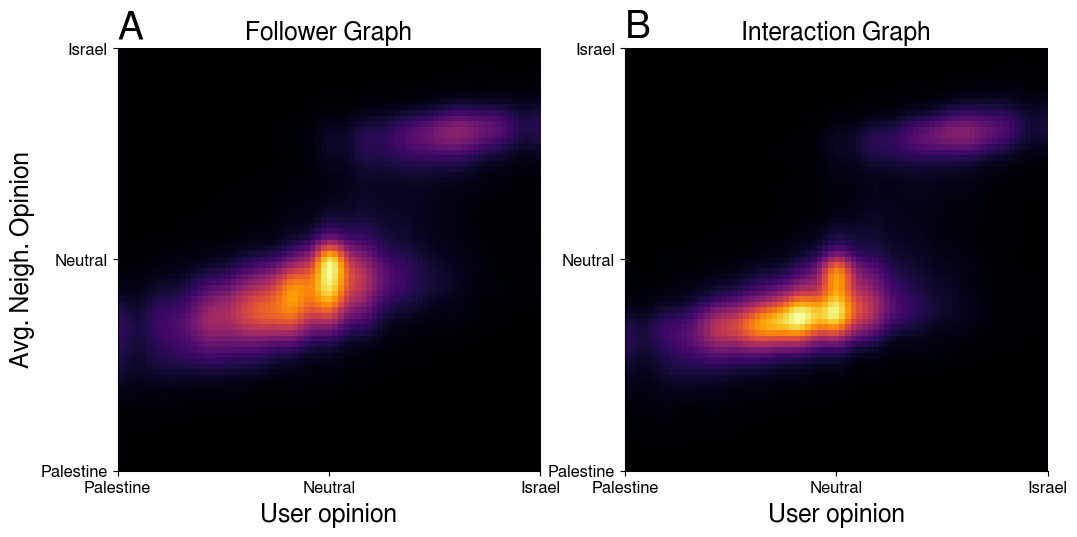

In [28]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'FreeSans']

# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Normalize the ratings
ratings_norm = (ratings - np.min(ratings)) / (np.max(ratings) - np.min(ratings))
neighbor_ratings_norm = (neighbor_ratings - np.min(neighbor_ratings)) / (np.max(neighbor_ratings) - np.min(neighbor_ratings))

ratings_interact_norm = (ratings_interact - np.min(ratings_interact)) / (np.max(ratings_interact) - np.min(ratings_interact))
neighbor_ratings_interact_norm = (neighbor_ratings_interact - np.min(neighbor_ratings_interact)) / (np.max(neighbor_ratings_interact) - np.min(neighbor_ratings_interact))

# Create heatmaps
heatmap1, xedges1, yedges1 = np.histogram2d(ratings_norm, neighbor_ratings_norm, bins=75, range=[[0, 1], [0, 1]])
heatmap2, xedges2, yedges2 = np.histogram2d(ratings_interact_norm, neighbor_ratings_interact_norm, bins=75, range=[[0, 1], [0, 1]])

extent1 = [xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]
extent2 = [xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]]

heatmap1 = heatmap1.T
heatmap2 = heatmap2.T

# Apply Gaussian smoothing
heatmap1 = ndimage.gaussian_filter(heatmap1, sigma=2)
heatmap2 = ndimage.gaussian_filter(heatmap2, sigma=2)

heatmap1 = heatmap1 / np.max(heatmap1)
heatmap2 = heatmap2 / np.max(heatmap2)

# Plot the heatmaps
im1 = ax1.imshow(heatmap1, extent=extent1, origin="lower", cmap="inferno", vmin=0, vmax=1)
im2 = ax2.imshow(heatmap2, extent=extent2, origin="lower", cmap="inferno", vmin=0, vmax=1)

# Set labels and ticks
ax1.set_xlabel("User opinion", fontsize=18)
ax1.set_ylabel("Avg. Neigh. Opinion", fontsize=18)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels(["Palestine", "Neutral", "Israel"], fontsize=12)
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels(["Palestine", "Neutral", "Israel"], fontsize=12)

ax2.set_xlabel("User opinion", fontsize=18)
#ax2.set_ylabel("Avg. Neigh. Opinion")
ax2.set_ylabel("")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xticks([0, 0.5, 1])
ax2.set_xticklabels(["Palestine", "Neutral", "Israel"], fontsize=12)
ax2.set_yticks([0, 0.5, 1])
ax2.set_yticklabels(["Palestine", "Neutral", "Israel"], fontsize=12)

# Set titles
ax1.set_title("Follower Graph", fontsize=18)
ax2.set_title("Interaction Graph", fontsize=18)

# Remove the top and right spines
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Add Panel Labels A and B
ax1.text(0, 1.025, "A", transform=ax1.transAxes, fontsize=28, color="black")
ax2.text(0, 1.025, "B", transform=ax2.transAxes, fontsize=28, color="black")

plt.savefig("../../Plots/Palestine_OpinionGraphs.png", dpi=300, bbox_inches="tight")
plt.savefig("../../Plots/Palestine_OpinionGraphs.pdf", bbox_inches="tight")

## Analyse Political Leaning of Users

In [25]:
# Load the data
conn = sqlite3.connect(db_path)
query = "SELECT * FROM posts WHERE Link IS NOT NULL AND Link != '';"
df = pd.read_sql(query, conn)

map_unshortened_df = pd.read_csv("../../Data/UnshortenBatches/unshortened_urls.csv.gz")
link2longlink = map_unshortened_df.set_index("link")["unshortened_url"].to_dict()
df["link"] = df["link"].apply(lambda x: link2longlink.get(x, x))

df["sourcedomain"] = df["link"].progress_apply(lambda x: extract(x).domain)
mediabias = pd.read_csv("../../Data/MBFC_Data/mediabiasfactcheck_fulldataset.csv")
mediabias = mediabias.dropna(subset=["sourcedomain", "political_level"])
mediabias = mediabias.loc[:, ["political_level", "sourcedomain"]]
df = df.merge(mediabias, on="sourcedomain", how="left")
rated = df[~df.political_level.isna()]

# Filter for user who posted at least 2 rated articles
multiple_posts = rated.groupby("did").size() >= 5
did2rating_mult = (
    rated[rated.did.isin(multiple_posts[multiple_posts].index)]
    .groupby("did")
    .political_level.mean()
    .to_dict()
)

100%|██████████| 9929672/9929672 [03:15<00:00, 50697.39it/s]


In [26]:
political_ratings_interact, political_neighbor_ratings_interact = get_ratings_and_neighbor_ratings(did2rating_mult, InteractGraph.did2idx, InteractGraph.G, Num_Neighbors = 5)
political_ratings, political_neighbor_ratings = get_ratings_and_neighbor_ratings(did2rating_mult, FollowGraph.did2idx, FollowGraph.G, Num_Neighbors = 5)

 22%|██▏       | 9582/43074 [00:04<00:15, 2118.75it/s]

100%|██████████| 43074/43074 [00:19<00:00, 2237.17it/s]


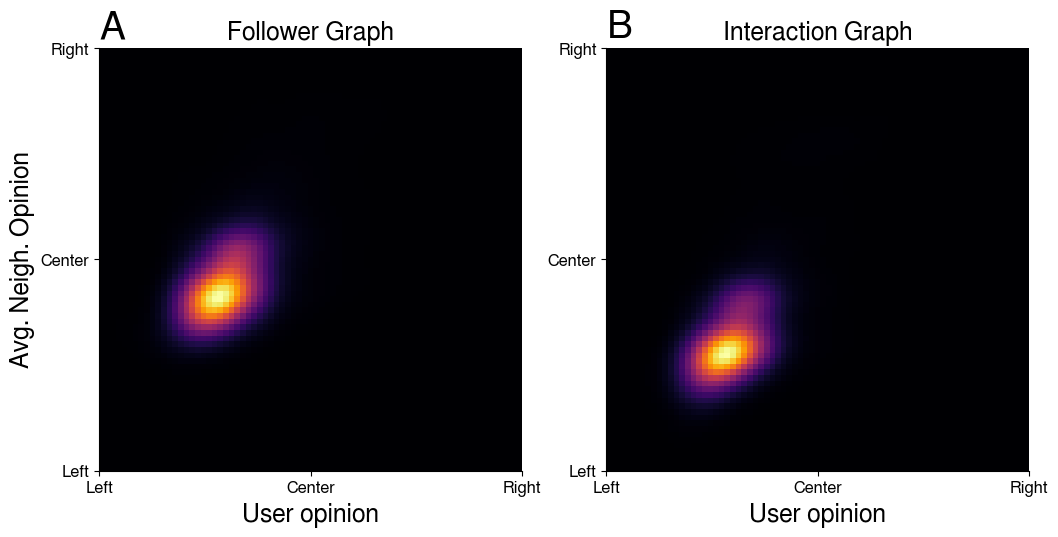

In [30]:
# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Normalize the ratings
ratings_norm = (political_ratings - np.min(political_ratings)) / (np.max(political_ratings) - np.min(political_ratings))
neighbor_ratings_norm = (political_neighbor_ratings - np.min(political_neighbor_ratings)) / (np.max(political_neighbor_ratings) - np.min(political_neighbor_ratings))

ratings_interact_norm = (political_ratings_interact - np.min(political_ratings_interact)) / (np.max(political_ratings_interact) - np.min(political_ratings_interact))
neighbor_ratings_interact_norm = (political_neighbor_ratings_interact - np.min(political_neighbor_ratings_interact)) / (np.max(political_neighbor_ratings_interact) - np.min(political_neighbor_ratings_interact))

# Create heatmaps
heatmap1, xedges1, yedges1 = np.histogram2d(ratings_norm, neighbor_ratings_norm, bins=75, range=[[0, 1], [0, 1]])
heatmap2, xedges2, yedges2 = np.histogram2d(ratings_interact_norm, neighbor_ratings_interact_norm, bins=75, range=[[0, 1], [0, 1]])

extent1 = [xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]
extent2 = [xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]]

heatmap1 = heatmap1.T
heatmap2 = heatmap2.T

# Apply Gaussian smoothing
heatmap1 = ndimage.gaussian_filter(heatmap1, sigma=2)
heatmap2 = ndimage.gaussian_filter(heatmap2, sigma=2)

heatmap1 = heatmap1 / np.max(heatmap1)
heatmap2 = heatmap2 / np.max(heatmap2)

# Plot the heatmaps
im1 = ax1.imshow(heatmap1, extent=extent1, origin="lower", cmap="inferno", vmin=0, vmax=1)
im2 = ax2.imshow(heatmap2, extent=extent2, origin="lower", cmap="inferno", vmin=0, vmax=1)

# Set labels and ticks
ax1.set_xlabel("User opinion", fontsize=18)
ax1.set_ylabel("Avg. Neigh. Opinion", fontsize=18)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels(["Left", "Center", "Right"], fontsize=12)
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels(["Left", "Center", "Right"], fontsize=12)

ax2.set_xlabel("User opinion", fontsize=18)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xticks([0, 0.5, 1])
ax2.set_xticklabels(["Left", "Center", "Right"], fontsize=12)
ax2.set_yticks([0, 0.5, 1])
ax2.set_yticklabels(["Left", "Center", "Right"], fontsize=12)

# Set titles
ax1.set_title("Follower Graph", fontsize=18)
ax2.set_title("Interaction Graph", fontsize=18)

# Remove the top and right spines
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Add Panel Labels A and B
ax1.text(0.0, 1.025, "A", transform=ax1.transAxes, fontsize=28, color="black")
ax2.text(0.0, 1.025, "B", transform=ax2.transAxes, fontsize=28, color="black")

# Adjust the layout and display the plot
plt.savefig("../../Plots/Political_OpinionGraphs.png", dpi=300, bbox_inches="tight")
plt.savefig("../../Plots/Political_OpinionGraphs.pdf", bbox_inches="tight")

/tmp/ipykernel_3253140/3152697760.py:278: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


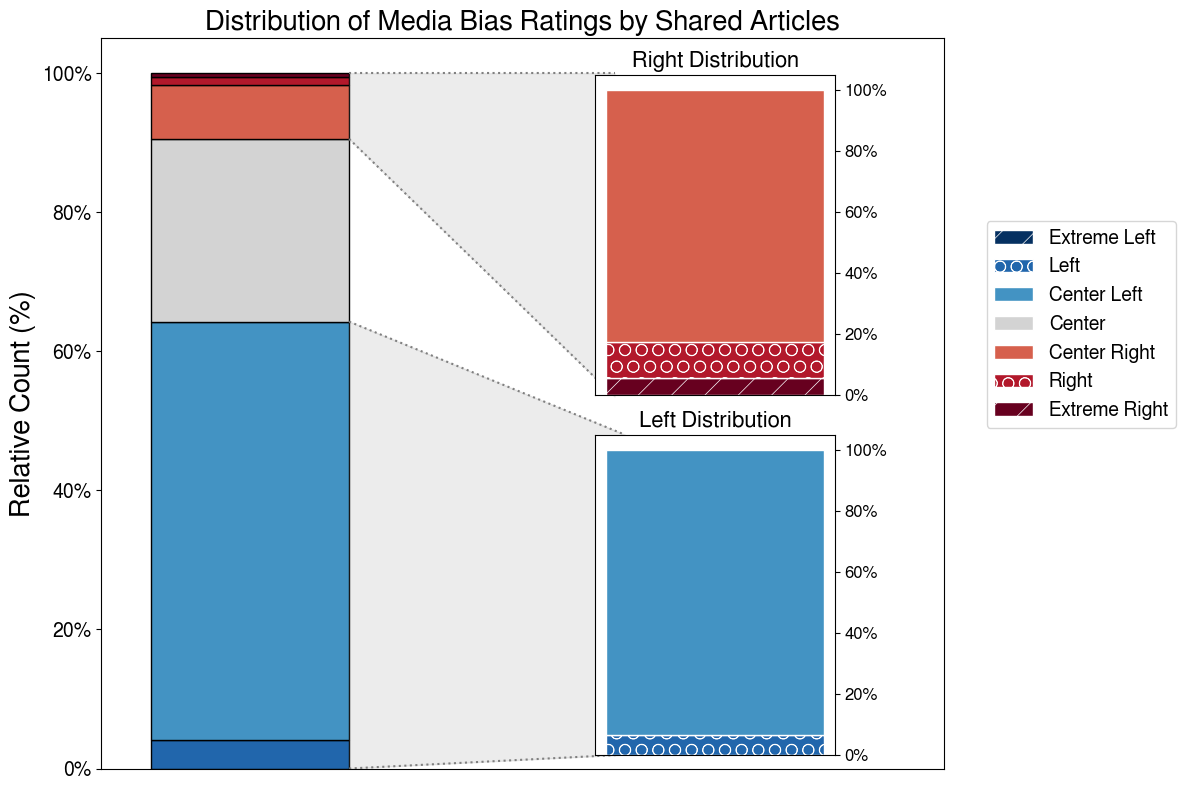

In [28]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'FreeSans']

# Calculate the counts for each category
left_extreme = rated[
    (rated.political_level >= -36) & (rated.political_level < -30)
].shape[0]
left_moderate = rated[
    (rated.political_level >= -30) & (rated.political_level < -18)
].shape[0]
left_center = rated[
    (rated.political_level >= -18) & (rated.political_level < -6)
].shape[0]
center = rated[(rated.political_level >= -6) & (rated.political_level < 6)].shape[0]
right_center = rated[(rated.political_level >= 6) & (rated.political_level < 18)].shape[0]
right_moderate = rated[
    (rated.political_level >= 18) & (rated.political_level < 30)
].shape[0]
right_extreme = rated[
    (rated.political_level >= 30) & (rated.political_level <= 36)
].shape[0]

# Calculate the total count
total_count = rated.shape[0]
main_plot_bar_width = 0.2

# Calculate the relative counts for each category
left_extreme_rel = left_extreme / total_count
left_moderate_rel = left_moderate / total_count
left_center_rel = left_center / total_count
center_rel = center / total_count
right_center_rel = right_center / total_count
right_moderate_rel = right_moderate / total_count
right_extreme_rel = right_extreme / total_count

# Create the main plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define the color gradient and patterns
colors = [
    "#053061",
    "#2166ac",
    "#4393c3",
    "#92c5de",
    "#d1e5f0",
    "#fddbc7",
    "#f4a582",
    "#d6604d",
    "#b2182b",
    "#67001f",
]

# Define patterns with increased density
stripe_pattern = "/"  # Multiple slashes for denser stripes
dot_pattern = 'O'       # Multiple dots for denser pattern
no_pattern = ''           # No pattern for center

# Set the hatch color to white
plt.rcParams['hatch.color'] = 'white'
# Increase hatch linewidth
plt.rcParams['hatch.linewidth'] = 0.5

# Create the main stacked bar chart (no patterns)
ax.bar(
    0, left_extreme_rel, color=colors[0], width=main_plot_bar_width, edgecolor="black"
)
ax.bar(
    0,
    left_moderate_rel,
    bottom=left_extreme_rel,
    color=colors[1],
    width=main_plot_bar_width,
    edgecolor="black",
)
ax.bar(
    0,
    left_center_rel,
    bottom=left_extreme_rel + left_moderate_rel,
    color=colors[2],
    width=main_plot_bar_width,
    edgecolor="black",
)
ax.bar(
    0,
    center_rel,
    bottom=left_extreme_rel + left_moderate_rel + left_center_rel,
    color="lightgrey",
    width=main_plot_bar_width,
    edgecolor="black",
)
ax.bar(
    0,
    right_center_rel,
    bottom=left_extreme_rel + left_moderate_rel + left_center_rel + center_rel,
    color=colors[7],
    width=main_plot_bar_width,
    edgecolor="black",
)
ax.bar(
    0,
    right_moderate_rel,
    bottom=left_extreme_rel + left_moderate_rel + left_center_rel + center_rel + right_center_rel,
    color=colors[8],
    width=main_plot_bar_width,
    edgecolor="black",
)
ax.bar(
    0,
    right_extreme_rel,
    bottom=left_extreme_rel + left_moderate_rel + left_center_rel + center_rel + right_center_rel + right_moderate_rel,
    color=colors[9],
    width=main_plot_bar_width,
    edgecolor="black",
)

right_start = 1 - right_center_rel - right_moderate_rel - right_extreme_rel
right_end = 1

left_start = 0
left_end = left_extreme_rel + left_moderate_rel + left_center_rel

sup_plot_x = 0.35

ax.set_xlim(-0.15, 0.7)
ax.set_xticks([])
ax.set_ylabel("Relative Count (%)", fontsize=20)
ax.set_title("Distribution of Media Bias Ratings by Shared Articles", fontsize=20)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.tick_params(axis="y", labelsize=14)

# Create the detailed Left stacked bar chart (with patterns)
ax2 = fig.add_axes([0.5, 0.05, 0.2, 0.4])
ax2.bar(
    0,
    left_extreme / (left_extreme + left_moderate + left_center),
    color=colors[0],
    edgecolor="white",
    hatch=stripe_pattern
)
ax2.bar(
    0,
    left_moderate / (left_extreme + left_moderate + left_center),
    bottom=left_extreme / (left_extreme + left_moderate + left_center),
    color=colors[1],
    edgecolor="white",
    hatch=dot_pattern
)
ax2.bar(
    0,
    left_center / (left_extreme + left_moderate + left_center),
    bottom=(left_extreme + left_moderate) / (left_extreme + left_moderate + left_center),
    color=colors[2],
    edgecolor="white",
    hatch=no_pattern
)
ax2.set_xticks([])
ax2.set_title("Left Distribution", fontsize=16)
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.tick_params(axis="y", labelsize=12)

# Create the detailed Right stacked bar chart (with patterns)
ax3 = fig.add_axes([0.5, 0.5, 0.2, 0.4])
ax3.bar(
    0,
    right_extreme / (right_center + right_moderate + right_extreme),
    color=colors[9],
    edgecolor="white",
    hatch=stripe_pattern
)
ax3.bar(
    0,
    right_moderate / (right_center + right_moderate + right_extreme),
    bottom=right_extreme / (right_center + right_moderate + right_extreme),
    color=colors[8],
    edgecolor="white",
    hatch=dot_pattern
)
ax3.bar(
    0,
    right_center / (right_center + right_moderate + right_extreme),
    bottom=(right_extreme + right_moderate) / (right_center + right_moderate + right_extreme),
    color=colors[7],
    edgecolor="white",
    hatch=no_pattern
)
ax3.set_xticks([])
ax3.set_title("Right Distribution", fontsize=16)
ax3.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.tick_params(axis="y", labelsize=12)

# Add zoom effect
zoom_effect_color = "gray"
zoom_effect_linewidth = 1.5
zoom_effect_linestyle = "dotted"
zoom_effect_alpha = 0.15

# Left wing zoom effect
ax.plot(
    [1.0 * main_plot_bar_width / 2, sup_plot_x * 1.08],
    [0.0, 0.02],
    color=zoom_effect_color,
    linewidth=zoom_effect_linewidth,
    linestyle=zoom_effect_linestyle,
)
ax.plot(
    [1.0 * main_plot_bar_width / 2, sup_plot_x * 1.08],
    [left_end, 0.48],
    color=zoom_effect_color,
    linewidth=zoom_effect_linewidth,
    linestyle=zoom_effect_linestyle,
)
ax.fill_between(
    [1.0 * main_plot_bar_width / 2, sup_plot_x * 1.08],
    [0.0, 0.02],
    [left_end, 0.48],
    color=zoom_effect_color,
    alpha=zoom_effect_alpha,
)

# Right wing zoom effect
ax.plot(
    [1.0 * main_plot_bar_width / 2, sup_plot_x * 1.05],
    [right_start, 0.535],
    color=zoom_effect_color,
    linewidth=zoom_effect_linewidth,
    linestyle=zoom_effect_linestyle,
)
ax.plot(
    [1.0 * main_plot_bar_width / 2, sup_plot_x * 1.05],
    [1.0, 1],
    color=zoom_effect_color,
    linewidth=zoom_effect_linewidth,
    linestyle=zoom_effect_linestyle,
)
ax.fill_between(
    [1.0 * main_plot_bar_width / 2, sup_plot_x * 1.05],
    [right_start, 0.535],
    [1.0, 1],
    color=zoom_effect_color,
    alpha=zoom_effect_alpha,
)

# Create legend with matching patterns
labels = [
    "Extreme Left",
    "Left",
    "Center Left",
    "Center",
    "Center Right",
    "Right",
    "Extreme Right",
]
handles = [
    plt.Rectangle((0, 0), 1, 1, facecolor=colors[0], hatch=stripe_pattern, edgecolor="white"),
    plt.Rectangle((0, 0), 1, 1, facecolor=colors[1], hatch=dot_pattern, edgecolor="white"),
    plt.Rectangle((0, 0), 1, 1, facecolor=colors[2], edgecolor="white"),
    plt.Rectangle((0, 0), 1, 1, facecolor="lightgrey", edgecolor="white"),
    plt.Rectangle((0, 0), 1, 1, facecolor=colors[7], edgecolor="white"),
    plt.Rectangle((0, 0), 1, 1, facecolor=colors[8], hatch=dot_pattern, edgecolor="white"),
    plt.Rectangle((0, 0), 1, 1, facecolor=colors[9], hatch=stripe_pattern, edgecolor="white"),
]
ax.legend(
    handles,
    labels,
    loc="upper left",
    bbox_to_anchor=(1.05, 0.75),
    borderaxespad=0.0,
    fontsize=14,
)

plt.tight_layout()
plt.savefig("../../Plots/media_bias_distribution.png", dpi=300)
plt.savefig("../../Plots/media_bias_distribution.pdf")